 # Deep Learning - Project

In [23]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import librosa
import librosa.display
import librosa.util
import IPython.display as ipd
import soundfile as sf
import torch
from torchaudio.transforms import MFCC
from IPython.display import Audio
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

 ## Load Data

### Check Directories

In [2]:
current_dir = os.getcwd()

print("Contents of the current directory:")
for item in os.listdir(current_dir):
    print(item)


Contents of the current directory:
.git
data_subsample
project.ipynb
README.md


In [3]:
data_dir = "data_subsample/"
languages = ["dutch", "english", "chinese", "italian"]


In [4]:
# Loop through languages
for language in languages:
    # language path
    language_path = os.path.join(data_dir, language)
    print("Language path:", language_path) 

    # Check if language path exists
    if os.path.isdir(language_path):
        # Get all directories inside the language folder
        subdirectories = [d for d in os.listdir(language_path) if os.path.isdir(os.path.join(language_path, d))]

        # Check if there are any subdirectories
        if subdirectories:
            # Print subdirectories
            print("Subdirectories:", subdirectories)
        else:
            print(f"No subdirectories found for {language}")

        # clips path
        clips_path = os.path.join(language_path, "clips")

        # Check if clips path exists
        if os.path.isdir(clips_path):
            # Count the number of files in the clips folder
            num_files = len(os.listdir(clips_path))
            print(f"Number of files in {language} clips folder:", num_files)
        else:
            print(f"No clips folder found for {language}")

        print(f"\n")
    else:
        print(f"No directory found for {language}")



Language path: data_subsample/dutch
Subdirectories: ['clips']
Number of files in dutch clips folder: 10


Language path: data_subsample/english
Subdirectories: ['clips']
Number of files in english clips folder: 10


Language path: data_subsample/chinese
Subdirectories: ['clips']
Number of files in chinese clips folder: 10


Language path: data_subsample/italian
Subdirectories: ['clips']
Number of files in italian clips folder: 10




### Investigate Length and Sampling Rate inspection per Language

In [5]:
def calculate_audio_length(audio_path):
    # Load audio file using librosa
    y, sr = librosa.load(audio_path, sr=None)
    # Compute duration of audio file in seconds
    duration = librosa.get_duration(y=y, sr=sr)
    return duration

def calculate_average_length(language_folder, max_instances=None):
    total_duration = 0.0
    total_files = 0
    instances_processed = 0

    language_path = os.path.join(data_dir, language_folder)

    # Check if it's a directory
    if os.path.isdir(language_path):
        # Iterate over clips folders
        for clips_folder in os.listdir(language_path):
            clips_path = os.path.join(language_path, clips_folder)

            # Check if it's a directory
            if os.path.isdir(clips_path):
                # Iterate over audio clips
                for audio_file in os.listdir(clips_path):
                    audio_path = os.path.join(clips_path, audio_file)
                    try:
                        # Calculate duration of audio file
                        duration = calculate_audio_length(audio_path)
                        total_duration += duration
                        total_files += 1
                        instances_processed += 1

                        if max_instances and instances_processed >= max_instances:
                            break  # Stop processing instances if limit reached
                    except Exception as e:
                        print(f"Error processing audio file {audio_file}: {e}")

    if total_files > 0:
        average_length = total_duration / total_files
        print(f"Average audio length for language {language_folder}: {average_length:.2f} seconds")
    else:
        print(f"No audio files found for language {language_folder}")


In [6]:
# Dictionary to store average audio lengths for each language
avg_lengths = {}

for language in languages:
    # Calculate average audio length
    avg_length=calculate_average_length(language, max_instances=10)
    avg_lengths[language] = avg_length


Average audio length for language dutch: 4.17 seconds
Average audio length for language english: 5.28 seconds
Average audio length for language chinese: 6.62 seconds
Average audio length for language italian: 6.34 seconds


In [7]:
def get_sampling_rate(language_folder, data_dir, max_instances=None, max_length=None):
    """
    Get the sampling rate from audio files within the clips directory of the specified language.

    Args:
    - language_folder (str): Name of the language folder.
    - data_dir (str): Path to the data directory containing language folders.
    - max_instances (int, optional): Maximum number of instances to read.
    - max_length (int, optional): Maximum length of audio files.

    Returns:
    - sampling_rate (int or None): Sampling rate of the audio files, or None if no audio files found.
    """
    # Construct the path to the clips directory for the specified language
    language_path = os.path.join(data_dir, language_folder, "clips")

    # Initialize an empty list to store sampling rates
    sampling_rates = []

    # Check if the clips directory exists
    if os.path.isdir(language_path):
        # Iterate over audio files in the directory
        for root, dirs, files in os.walk(language_path):
            for file in files:
                # Check if the file is an audio file (you can modify this condition if needed)
                if file.endswith(('.wav', '.mp3', '.flac')):
                    # Construct the full path to the audio file
                    file_path = os.path.join(root, file)
                    try:
                        # Open the audio file and read the sampling rate
                        with sf.SoundFile(file_path) as f:
                            sampling_rate = f.samplerate
                            # Append the sampling rate to the list
                            sampling_rates.append(sampling_rate)

                        # Check if maximum instances limit reached
                        if max_instances and len(sampling_rates) >= max_instances:
                            break
                    except Exception as e:
                        print(f"Error reading sampling rate from {file}: {e}")

        # If there are no audio files, return None
        if not sampling_rates:
            return None

        # Calculate the most common sampling rate
        sampling_rate = max(set(sampling_rates), key=sampling_rates.count)
        return sampling_rate
    else:
        print(f"No clips directory found for language {language_folder}")
        return None


In [8]:
for language in languages:
    sampling_rate = get_sampling_rate(language, data_dir)
    print(f"Sampling rate for {language} language: {sampling_rate}")


Sampling rate for dutch language: 48000
Sampling rate for english language: 32000
Sampling rate for chinese language: 48000
Sampling rate for italian language: 48000


### Load data and store instances' durations (across all languages)

In [10]:
def load_audio_data(data_dir, language_folder, max_instances=None, max_length=None):

    """
    Load and process audio data from a specified directory for a given language, 
    performing silence removal and uniform segmentation based on the specified clip length (MAX_LENGTH).

    This function operates in two main phases:
    1. Silence Removal: trims silence from the beginning and end of each audio clip.
    2. Uniform Segmentation: segments each trimmed audio clip into smaller, fixed-length segments 
       based on a predetermined maximum length (MAX_LENGTH) if specified (or uses a default length: 5 seconds), 
       ensuring uniformity of segment length across the dataset.
    """

    data = []
    labels = []
    original_durations = []  # original durations of audio files before any processing
    no_silences_durations = []  # durations after silence removal but before segmentation
    segmented_durations = []  # durations of the segmented clips, uniform and based on fixed_segment_samples
    segment_counts = {}  # track the number of segments per original audio file


    language_path = os.path.join(data_dir, language_folder)

    if os.path.isdir(language_path): # Check if it's a directory, then iterate over audio clips
        for clips_folder in os.listdir(language_path):
            clips_path = os.path.join(language_path, clips_folder)

            if os.path.isdir(clips_path): # Check if it's a directory, then iterate over audio clips
                for idx, audio_file in enumerate(os.listdir(clips_path)):
                    if max_instances and idx >= max_instances: # Stop reading instances if limit reached
                        break  

                    audio_path = os.path.join(clips_path, audio_file)
                    try:
                        y, sr = librosa.load(audio_path, sr=48000) # Load with hardcoded sr, change to None as preferred
                        original_duration = librosa.get_duration(y=y, sr=sr)
                        original_durations.append(original_duration)
                        
                        y_trimmed, index = librosa.effects.trim(y)  # Silence removal
                        no_silences_duration = librosa.get_duration(y=y_trimmed, sr=sr)
                        no_silences_durations.append(no_silences_duration)

                        # Calculate the fixed segment size in samples
                        fixed_segment_samples = int(max_length * sr) if max_length else sr * 5  # Default to 5 seconds if max_length is None
                        
                        # Segment the audio file
                        num_segments = len(y_trimmed) // fixed_segment_samples
                        segment_counts[(audio_path, language)] = num_segments
                        
                        for segment in range(num_segments):
                            start_sample = segment * fixed_segment_samples
                            end_sample = start_sample + fixed_segment_samples
                            segment_samples = y_trimmed[start_sample:end_sample]
                            data.append(segment_samples)
                            labels.append(language_folder)
                            segmented_durations.append(fixed_segment_samples / sr)  # Compute segment duration in seconds
                        
                    except Exception as e:
                        print(f"Error loading audio file {audio_file}: {e}")
    else:
        print(f"Language folder not found: {language_folder}")

    return np.array(data, dtype=object), np.array(labels), np.array(original_durations), np.array(no_silences_durations), np.array(segmented_durations), segment_counts
  

In [27]:
MAX_INSTANCES = 10  # max number of instances to read
MAX_LENGTH = 2.5  # seconds of audio

"""""
 The MAX_LENGTH parameter now is used to set the duration of the shortest audio clip found 
 (after silence removal across all instances) ensuring uniformity of segment sizes.
 Currently the shortest audio clip found after silence removal across all instances can only 
 be ascertained after running this cell, so the default 5 seconds can be used first.
"""""

X_all = []
y_all = []
original_durations_all = []  # original durations from all languages
no_silences_durations_all = [] 
segmented_durations_all = []  # durations of segmented clips
segment_counts_all = {}  # hold all segment counts

for language in languages:
    X_lang, y_lang, original_durations_lang, no_silences_durations_lang, segmented_durations_lang, segment_counts_lang = load_audio_data(data_dir, language, max_instances=MAX_INSTANCES, max_length=MAX_LENGTH)

    X_all.extend(X_lang)
    y_all.extend(y_lang)
    original_durations_all.extend(original_durations_lang)
    no_silences_durations_all.extend(no_silences_durations_lang)
    segmented_durations_all.extend(segmented_durations_lang)

    # Merge current language's segment counts into the overall segment counts dictionary
    for key, value in segment_counts_lang.items():
        segment_counts_all[key] = segment_counts_all.get(key, 0) + value

# Verify uniform lengths if MAX_LENGTH was correctly enforced
print([len(segment) for segment in X_all]) 

# Convert lists to numpy arrays, assuming segments are now uniformly sized
X_all = np.array(X_all, dtype=np.float32)
y_all = np.array(y_all)
original_durations_all = np.array(original_durations_all)
no_silences_durations_all = np.array(no_silences_durations_all)
segmented_durations_all = np.array(segmented_durations_all)


[120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000]


In [28]:
# adjust MAX_LENGTH according to this value
np.min(no_silences_durations_all)

2.509333333333333

### Check Durations and Distributions

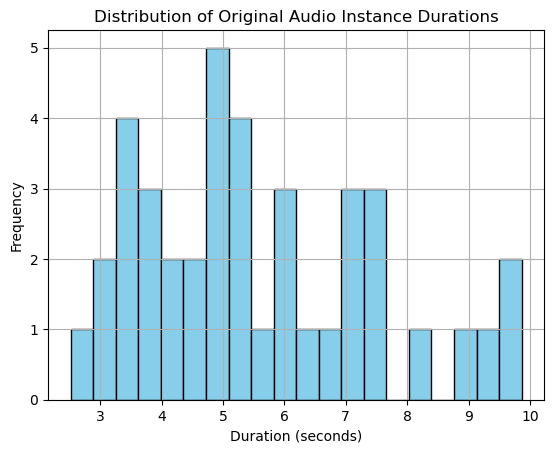

Maximum original duration of audio instances: 9.864 seconds
Minimum original duration of audio instances: 2.52 seconds
Average original duration of audio instances: 5.6028 seconds


In [29]:
# Plot a histogram of the original durations
plt.hist(original_durations_all, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Original Audio Instance Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate and print statistics for original durations
max_duration_original = np.max(original_durations_all)
print("Maximum original duration of audio instances:", max_duration_original, "seconds")
min_duration_original = np.min(original_durations_all)
print("Minimum original duration of audio instances:", min_duration_original, "seconds")
avg_duration_original = np.mean(original_durations_all)
print("Average original duration of audio instances:", avg_duration_original, "seconds")

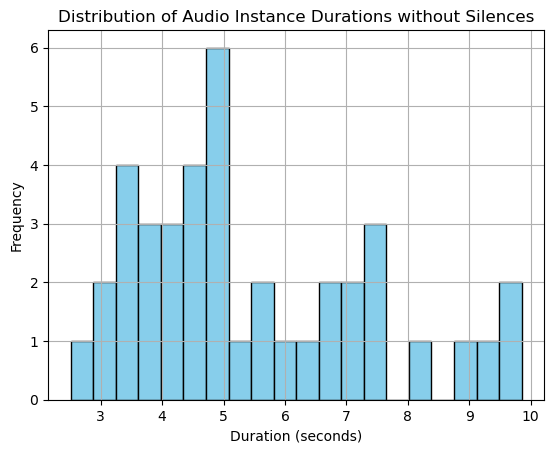

Maximum duration of audio instances without silences: 9.853333333333333 seconds
Minimum duration of audio instances without silences: 2.509333333333333 seconds
Average duration of audio instances without silences: 5.4631 seconds


In [30]:
# Plot a histogram of the original durations
plt.hist(no_silences_durations_all, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Audio Instance Durations without Silences')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate and print statistics for original durations
max_duration_original = np.max(no_silences_durations_all)
print("Maximum duration of audio instances without silences:", max_duration_original, "seconds")
min_duration_original = np.min(no_silences_durations_all)
print("Minimum duration of audio instances without silences:", min_duration_original, "seconds")
avg_duration_original = np.mean(no_silences_durations_all)
print("Average duration of audio instances without silences:", avg_duration_original, "seconds")

In [31]:
language_distribution = Counter(y_all)
for language, count in language_distribution.items():
    print(f"Segments obtained from the {language} language: {count}")

Segments obtained from the dutch language: 11
Segments obtained from the english language: 12
Segments obtained from the chinese language: 21
Segments obtained from the italian language: 19


In [33]:
total_segments_per_language = Counter(y_all)  # This remains the same, as y_all holds language labels

for (original_file, language), segment_count in segment_counts_all.items():
    total_segments = total_segments_per_language.get(language, 0)
    percentage_representation = (segment_count / total_segments) * 100 if total_segments > 0 else 0
    filename = os.path.basename(original_file)
    print(f"{filename}: {percentage_representation:.2f}% of all {language} segments")

common_voice_nl_17691032.mp3: 9.09% of all dutch segments
common_voice_nl_17691033.mp3: 9.09% of all dutch segments
common_voice_nl_17691034.mp3: 9.09% of all dutch segments
common_voice_nl_17691035.mp3: 9.09% of all dutch segments
common_voice_nl_17691036.mp3: 9.09% of all dutch segments
common_voice_nl_17691467.mp3: 9.09% of all dutch segments
common_voice_nl_17691468.mp3: 9.09% of all dutch segments
common_voice_nl_17691469.mp3: 18.18% of all dutch segments
common_voice_nl_17691470.mp3: 9.09% of all dutch segments
common_voice_nl_17691471.mp3: 9.09% of all dutch segments
common_voice_en_37285574.mp3: 16.67% of all english segments
common_voice_en_37285575.mp3: 8.33% of all english segments
common_voice_en_37285576.mp3: 8.33% of all english segments
common_voice_en_37285577.mp3: 8.33% of all english segments
common_voice_en_37285578.mp3: 8.33% of all english segments
common_voice_en_37285724.mp3: 8.33% of all english segments
common_voice_en_37285725.mp3: 16.67% of all english segmen

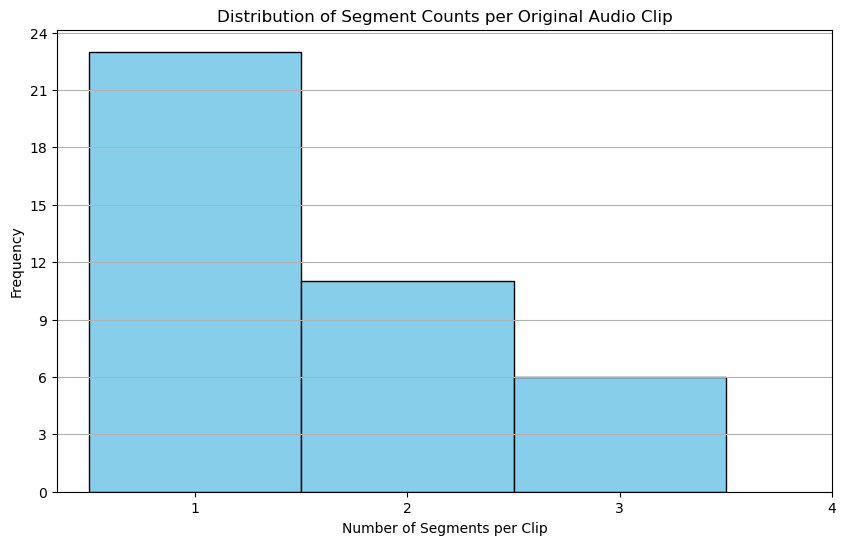

In [25]:
# Extract segment counts from segment_counts_all
segment_counts = [count for (_, _), count in segment_counts_all.items()]

# Create a histogram of segment counts
plt.figure(figsize=(10, 6))
plt.hist(segment_counts, bins=range(min(segment_counts), max(segment_counts) + 2), 
         color='skyblue', edgecolor='black', align='left')
plt.title('Distribution of Segment Counts per Original Audio Clip')
plt.xlabel('Number of Segments per Clip')
plt.ylabel('Frequency')
plt.xticks(range(min(segment_counts), max(segment_counts) + 2)) 
plt.grid(axis='y')
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

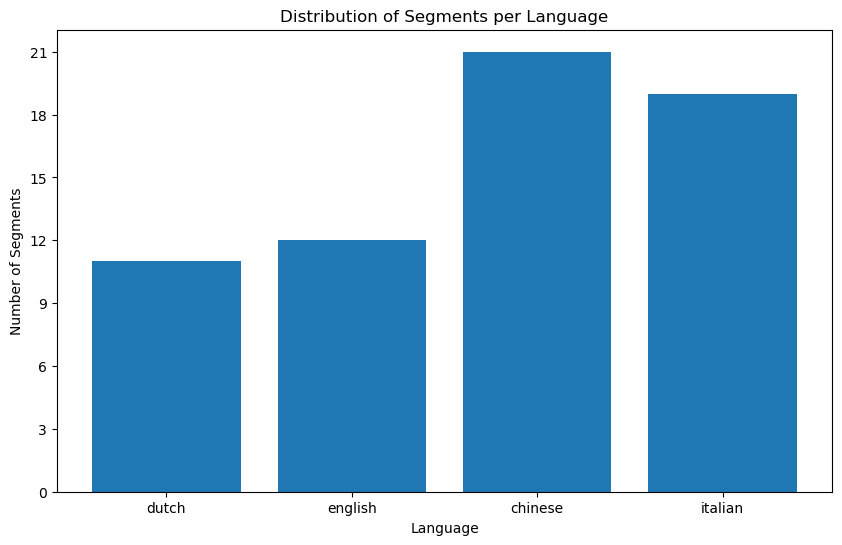

In [26]:
# Histogram of segment counts per language
plt.figure(figsize=(10, 6))
languages = list(language_distribution.keys())
counts = list(language_distribution.values())
plt.bar(languages, counts)
plt.xlabel('Language')
plt.ylabel('Number of Segments')
plt.title('Distribution of Segments per Language')
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

 # Inspect the data DIRECTLY FROM LOAD


In [91]:

def inspect_audio_data(data_dir, languages, language_dict):
    """
    Inspects the audio data by printing language paths, subdirectories, and the number of files in clips folders.
    Also plots the waveform of a randomly selected audio sample for each language.

    Args:
    - data_dir (str): Path to the data directory containing language folders.
    - languages (list): List of language names.
    - language_dict (dict): Dictionary mapping language names to integers.
    """
    for language in languages:
        # Language path
        language_path = os.path.join(data_dir, language)
        print("Language path:", language_path) 

        # Check if language path exists
        if os.path.isdir(language_path):
            # Get all directories inside the language folder
            subdirectories = [d for d in os.listdir(language_path) if os.path.isdir(os.path.join(language_path, d))]

            # Check if there are any subdirectories
            if subdirectories:
                # Print subdirectories
                print("Subdirectories:", subdirectories)
            else:
                print(f"No subdirectories found for {language}")

            # Clips path
            clips_path = os.path.join(language_path, "clips")

            # Check if clips path exists
            if os.path.isdir(clips_path):
                # Count the number of files in the clips folder
                num_files = len(os.listdir(clips_path))
                print(f"Number of files in {language} clips folder:", num_files)
            else:
                print(f"No clips folder found for {language}")

            print(f"\n")
            
            # Plot waveform of a randomly selected audio sample
            if num_files > 0:
                # Randomly select an audio file
                audio_files = os.listdir(clips_path)
                random_audio_file = np.random.choice(audio_files)
                audio_path = os.path.join(clips_path, random_audio_file)

                # Load audio file using librosa
                audio, sr = librosa.load(audio_path, sr=None)

                # Plot waveform
                plt.figure(figsize=(10, 4))
                plt.plot(np.arange(len(audio)) / sr, audio)
                plt.title(f"Waveform of a randomly selected audio sample for {language} language")
                plt.xlabel("Time (seconds)")
                plt.ylabel("Amplitude")
                plt.show()

                # Play audio
                display(Audio(audio, rate=sr))
        else:
            print(f"No directory found for {language}")


Language path: data_subsample/dutch
Subdirectories: ['clips']
Number of files in dutch clips folder: 10




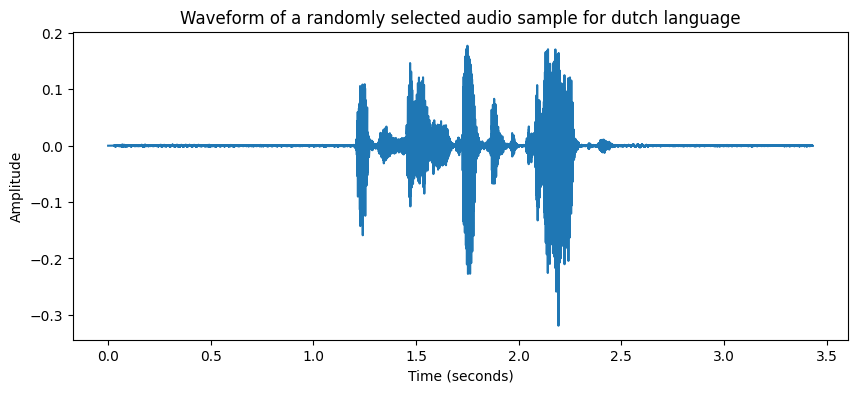

Language path: data_subsample/english
Subdirectories: ['clips']
Number of files in english clips folder: 10




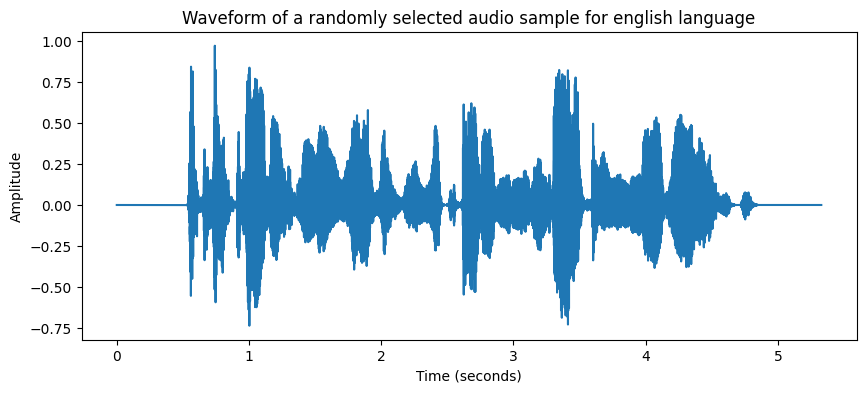

Language path: data_subsample/chinese
Subdirectories: ['clips']
Number of files in chinese clips folder: 10




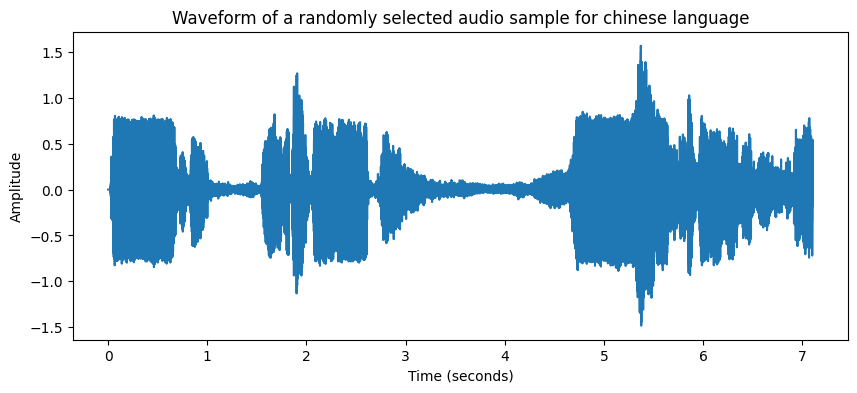

Language path: data_subsample/italian
Subdirectories: ['clips']
Number of files in italian clips folder: 10




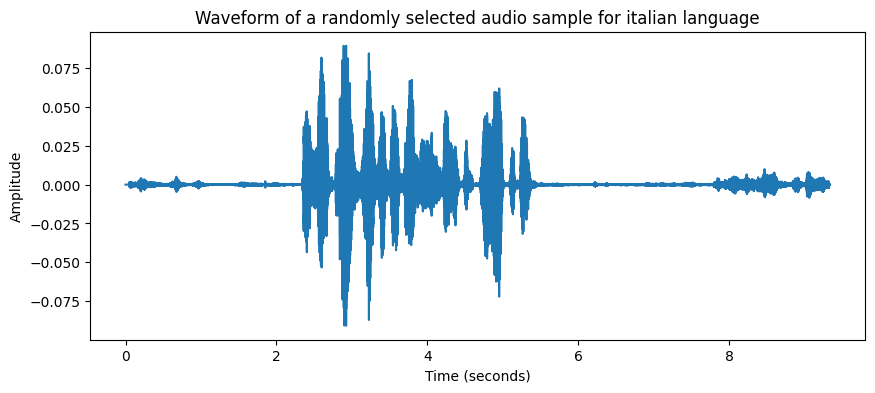

In [92]:
# Example usage
data_dir = "data_subsample"
languages = ["dutch", "english", "chinese", "italian"]
language_dict = {languages[i]: i for i in range(len(languages))}

inspect_audio_data(data_dir, languages, language_dict)

 # Inspect the CURRENT DATA

In [93]:
def inspect_audio_data(X, y, languages):
    """
    Inspects the loaded audio data.

    Args:
    - X (numpy.ndarray): Array containing audio data.
    - y (numpy.ndarray): Array containing labels corresponding to the audio data.
    - languages (list): List of language labels.

    Returns:
    None
    """
    # Print basic information about the dataset
    print("Dataset Information:")
    print("Number of audio samples:", len(X))
    print("Number of unique languages:", len(np.unique(y)))
    print("Languages:", np.unique(y))

    # Plot distribution of classes
    plt.figure(figsize=(10, 6))
    plt.hist(y, bins=len(np.unique(y)), edgecolor='black', alpha=0.7)
    plt.title("Distribution of Classes")
    plt.xlabel("Language")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Plot example waveforms for each language
    for language in languages:
        plt.figure(figsize=(10, 2))
        samples = X[y == language]
        num_samples = min(len(samples), 3)  # Plot up to 5 samples per language
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.plot(samples[i])
            plt.title(f"{language} Sample {i+1}")
            plt.xlabel("Sample Index")
            plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()



Dataset Information:
Number of audio samples: 40
Number of unique languages: 4
Languages: ['chinese' 'dutch' 'english' 'italian']


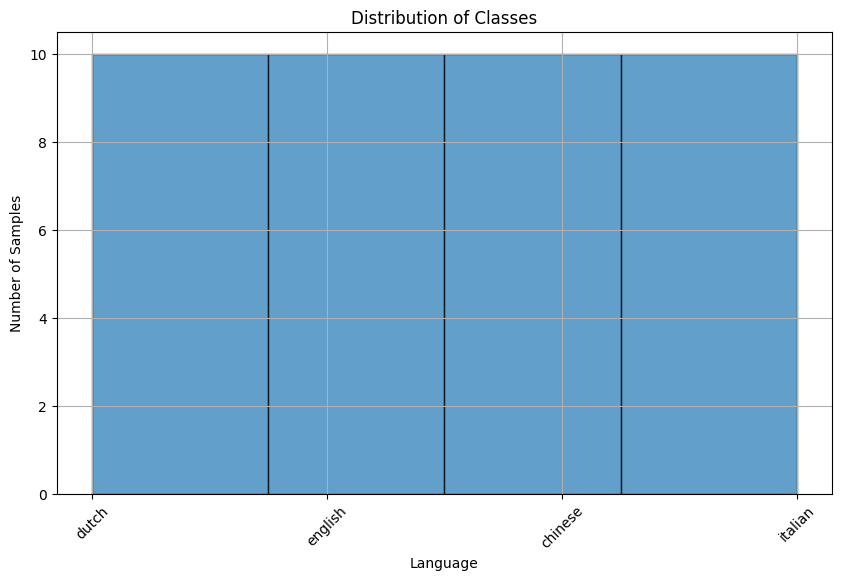

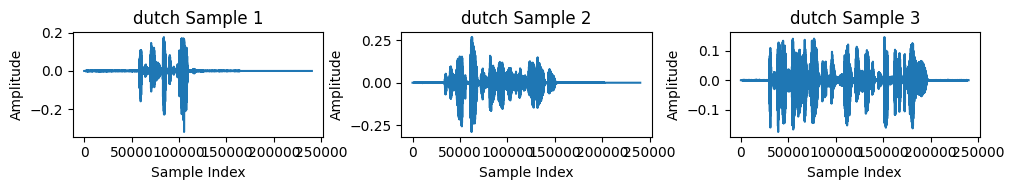

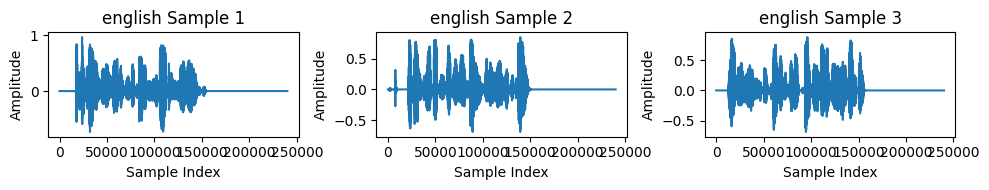

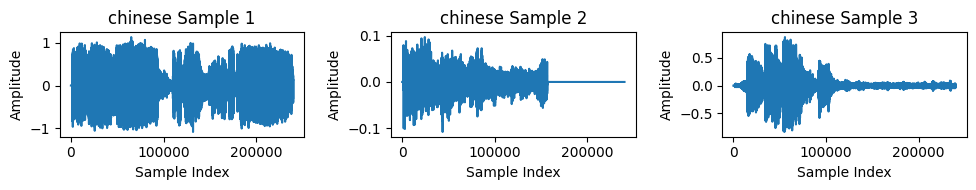

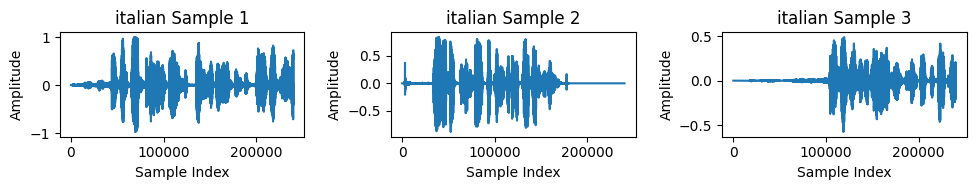

In [94]:
inspect_audio_data(X_all, y_all, languages)

 ## Normalize and Transform Input

In [95]:
def normalize_and_transform(X, sampling_rate):
    normalized_data = []
    mfcc_transform = MFCC(sample_rate=sampling_rate)

    for x in X:
        # Z-score normalization
        mean = np.mean(x)
        std = np.std(x)
        x_normalized = (x - mean) / std

        # Compute MFCC transform
        x_mfcc = mfcc_transform(torch.tensor(x_normalized))

        # Append the normalized and transformed data
        normalized_data.append(x_mfcc)

    return normalized_data

def visualize_mfccs(mfccs):
    """
    Visualizes MFCCs.
    """
    for mfcc in mfccs:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc.numpy(), x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        plt.show()


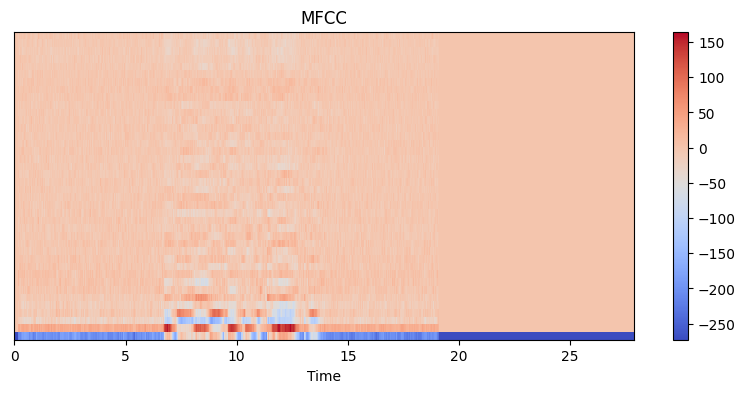

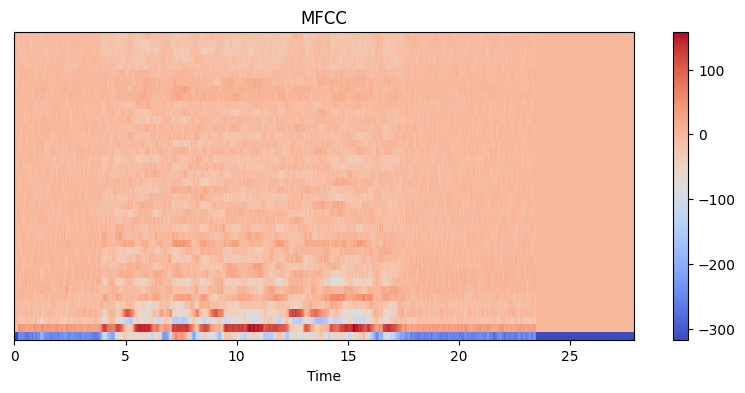

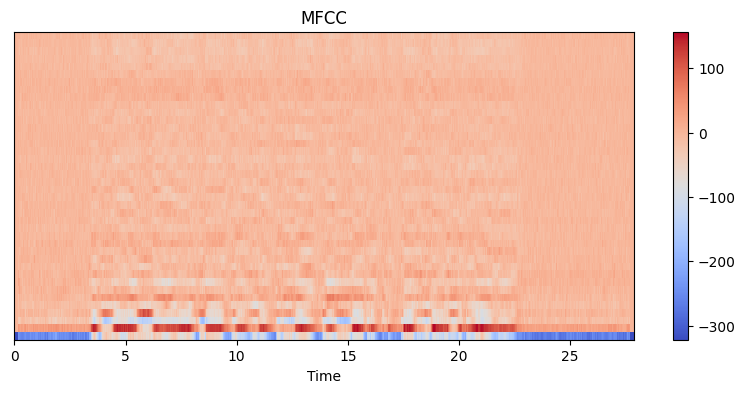

In [107]:
normalized_and_transformed_data = normalize_and_transform(X_all, sampling_rate)
visualize_mfccs(normalized_and_transformed_data[:3])

 ## Create Spectrograms

In [97]:
# def compute_mel_spectrograms(X, sampling_rate):
#     """
#     Computes the Mel spectrogram for all audio clips in X.
#     """
#     spectrograms = []

#     for x in X:
#         # Compute Mel spectrogram
#         S = librosa.feature.melspectrogram(y=x, sr=sampling_rate, fmax = 1600)

#         # Convert to dB scale
#         S_db = librosa.power_to_db(S, ref=np.max)
        
#         spectrograms.append(S_db)

#     return spectrograms   


# def visualize_mel_spectrograms(spectrograms, sampling_rate):
#     """
#     Creates a figure for all Mel spectrograms in spectrograms.
#     """
    
#     for S_db in spectrograms:
#         # Plot Mel spectrogram
#         plt.figure(figsize=(10, 4))
#         librosa.display.specshow(S_db, sr=sampling_rate, x_axis='time', y_axis='mel')
#         plt.colorbar(format='%+2.0f dB')
#         plt.title('Mel spectrogram')
#         plt.show()


In [108]:

# specs = compute_mel_spectrograms(normalized_data, sampling_rate)
# visualize_mel_spectrograms(specs, sampling_rate)

 # Create the model

## Split in train, test

In [99]:
x_train, x_test, y_train, y_test = train_test_split(specs, y_all, stratify=y_all, test_size=0.3, random_state=0)

# Step 1: Use LabelEncoder to map string labels to integer indices
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Step 2: Convert integer indices to one-hot encoded format
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

#__________________________________________

# Convert data to numpy arrays
x_train_np = np.array(x_train)
x_test_np = np.array(x_test)

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train_np[:, np.newaxis], dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_np[:, np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_one_hot, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_one_hot, dtype=torch.float32)

# Split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_tensor, y_train_tensor, test_size=0.3, random_state=0)


# Define dataset and dataloaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# Print the shape of the data tensor in the dataset
print("Shape of training data tensor:", train_dataset.tensors[0].shape)
print("Shape of training label tensor:", train_dataset.tensors[1].shape)
print("Shape of validation data tensor:", val_dataset.tensors[0].shape)
print("Shape of validation label tensor:", val_dataset.tensors[1].shape)
print("Shape of test data tensor:", x_test_tensor.shape)
print("Shape of test label tensor:", y_test_tensor.shape)



Shape of training data tensor: torch.Size([19, 1, 128, 469])
Shape of training label tensor: torch.Size([19, 4])
Shape of validation data tensor: torch.Size([9, 1, 128, 469])
Shape of validation label tensor: torch.Size([9, 4])
Shape of test data tensor: torch.Size([12, 1, 128, 469])
Shape of test label tensor: torch.Size([12, 4])


In [109]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cpu


In [101]:
print(x_train)
spectrogram_shape = x_train[0].shape
print("Shape of input spectrograms:", spectrogram_shape)

tensor([[[[-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
          [-74.5588, -68.5514, -60.3527,  ..., -71.7414, -67.4843, -56.9587],
          [-80.0000, -79.3450, -71.1462,  ..., -80.0000, -78.2779, -67.7523],
          ...,
          [-80.0000, -80.0000, -57.2397,  ..., -71.2309, -54.4962, -47.1306],
          [-80.0000, -80.0000, -58.9225,  ..., -74.4998, -56.1200, -48.2754],
          [-80.0000, -80.0000, -59.4457,  ..., -74.0235, -57.6679, -50.0533]]],


        [[[-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
          [-80.0000, -80.0000, -59.7704,  ..., -80.0000, -80.0000, -80.0000],
          [-80.0000, -80.0000, -70.5639,  ..., -80.0000, -80.0000, -80.0000],
          ...,
          [-80.0000, -80.0000, -79.6047,  ..., -80.0000, -80.0000, -80.0000],
          [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
          [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000]]],


        [[[-80.0000, -80.0

In [102]:
"""
Each spectrogram is represented as a 2D array (matrix) of float32 values.
The shape of each spectrogram array is (128, 469).

128: This represents the number of frequency bins or "height" of each spectrogram. In spectrogram representation, 
frequencies are typically displayed along the vertical axis, and this number indicates the resolution of frequency 
components captured in the spectrogram. Higher values mean finer frequency resolution.

469: This represents the number of time frames or "width" of each spectrogram. In spectrogram representation, 
time is typically displayed along the horizontal axis, and this number indicates the duration of the audio signal captured in the spectrogram. 
Higher values mean capturing more time intervals or longer duration.

So, each spectrogram in the dataset has 128 frequency bins and 469 time frames.
"""

# Define the model
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization 
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.bn3= nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Define max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # I AM NOT SURE IF THIS IS THE BEST WAY TO DO IT. 
        # Calculate the size of the input to the fully connected layer
        self.fc_input_size = self._get_fc_input_size()
        
        # Define fully connected layers
        self.fc1 = nn.Linear(in_features=self.fc_input_size, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, x):
        # Apply convolutional and pooling layers
        x = F.leaky_relu(self.bn1(self.conv1(x)))  
        x = self.pool(x)
        x = F.leaky_relu(self.bn2(self.conv2(x)))  
        x = self.pool(x)
        x = F.leaky_relu(self.bn3(self.conv3(x))) 
        x = self.pool(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)))  
        x = self.pool(x)
        
        # Flatten the output for fully connected layers
        x = x.view(-1, self.fc_input_size)
        
        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def _get_fc_input_size(self):
        # Dummy input to compute the size of the output tensor after convolution and pooling
        x = torch.randn(1, 1, 128, 469)  # Assuming input shape (1, 128, 469)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        return x.numel()

# Initialize the model
num_classes = 4  # Change this based on the number of classes in your dataset
model = AudioClassifier(num_classes)

print(model)

AudioClassifier(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=41472, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
)


In [103]:


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    predicted = torch.argmax(outputs, dim=1)
    correct = (predicted == torch.argmax(y_test_tensor, dim=1)).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")

Epoch [1/50], Loss: 1.4118
Epoch [2/50], Loss: 8.4452
Epoch [3/50], Loss: 40.8575
Epoch [4/50], Loss: 35.2929
Epoch [5/50], Loss: 10.3166
Epoch [6/50], Loss: 6.4285
Epoch [7/50], Loss: 3.3340
Epoch [8/50], Loss: 0.7634
Epoch [9/50], Loss: 0.1533
Epoch [10/50], Loss: 0.6599
Epoch [11/50], Loss: 0.3195
Epoch [12/50], Loss: 0.1141
Epoch [13/50], Loss: 0.0000
Epoch [14/50], Loss: 0.0000
Epoch [15/50], Loss: 0.0000
Epoch [16/50], Loss: 0.0000
Epoch [17/50], Loss: 0.0000
Epoch [18/50], Loss: 0.0000
Epoch [19/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [21/50], Loss: 0.0000
Epoch [22/50], Loss: 0.0000
Epoch [23/50], Loss: 0.0000
Epoch [24/50], Loss: 0.0000
Epoch [25/50], Loss: 0.0000
Epoch [26/50], Loss: 0.0000
Epoch [27/50], Loss: 0.0000
Epoch [28/50], Loss: 0.0000
Epoch [29/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [31/50], Loss: 0.0000
Epoch [32/50], Loss: 0.0000
Epoch [33/50], Loss: 0.0000
Epoch [34/50], Loss: 0.0000
Epoch [35/50], Loss: 0.0000
Epoch [36/50], Loss: 0.000

In [104]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    
    # Evaluate the model on validation set
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, torch.argmax(labels, dim=1))
            val_running_loss += val_loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_accuracy:.4f}")



Epoch [1/20], Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 23.0969, Val Acc: 0.5556
Epoch [2/20], Train Loss: 5.2295, Train Acc: 0.7895, Val Loss: 3.9628, Val Acc: 0.6667
Epoch [3/20], Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 21.9319, Val Acc: 0.3333
Epoch [4/20], Train Loss: 1.6756, Train Acc: 0.8947, Val Loss: 34.1897, Val Acc: 0.3333
Epoch [5/20], Train Loss: 6.8947, Train Acc: 0.6842, Val Loss: 29.9992, Val Acc: 0.2222
Epoch [6/20], Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 28.8359, Val Acc: 0.4444
Epoch [7/20], Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 41.4220, Val Acc: 0.4444
Epoch [8/20], Train Loss: 0.0368, Train Acc: 0.9474, Val Loss: 50.1717, Val Acc: 0.3333
Epoch [9/20], Train Loss: 0.3011, Train Acc: 0.9474, Val Loss: 44.8914, Val Acc: 0.3333
Epoch [10/20], Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 42.3816, Val Acc: 0.3333
Epoch [11/20], Train Loss: 0.1292, Train Acc: 0.9474, Val Loss: 40.2642, Val Acc: 0.3333
Epoch [12/20], Train Loss: 0.07

In [105]:
# Final evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    predicted = torch.argmax(outputs, dim=1)
    correct = (predicted == torch.argmax(y_test_tensor, dim=1)).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f"Final Test Accuracy: {accuracy:.4f}")

Final Test Accuracy: 0.3333
